In [1]:
#!pip install lifelines
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import WeibullFitter,\
                      ExponentialFitter,\
                      LogNormalFitter,\
                      LogLogisticFitter,\
                      WeibullAFTFitter,\
                      LogNormalAFTFitter,\
                      LogLogisticAFTFitter

In [3]:
#Let's drop the 'ID' column as it's just an identifier and not useful for modeling.
telco_df = pd.read_csv("telco.csv")
telco_df = telco_df.drop('ID', axis=1)
telco_df.head()

,region,tenure,age,marital,address,income,ed,retire,gender,voice,internet,forward,custcat,churn
0,Zone 2,13,44,Married,9,64,College degree,No,Male,No,No,Yes,Basic service,Yes
1,Zone 3,11,33,Married,7,136,Post-undergraduate degree,No,Male,Yes,No,Yes,Total service,Yes
2,Zone 3,68,52,Married,24,116,Did not complete high school,No,Female,No,No,No,Plus service,No
3,Zone 2,33,33,Unmarried,12,33,High school degree,No,Female,No,No,No,Basic service,Yes
4,Zone 2,23,30,Married,9,30,Did not complete high school,No,Male,No,No,Yes,Plus service,No


## Data Transformation

### I will transform the 'churn' column to a binary format where 'Yes' is 1 and 'No' is  .
This step is crucial for converting the target variable into a format suitable for survival analysis and binary classification models.

### I will encode categorical variables (like 'region', 'marital', 'ed', etc.) into dummy variables for modeling, while dropping the first category to avoid multicollineaity.
Encoding categorical variables is essential for including them in the model. Dropping the first category of each encoded variable helps prevent multicollinearity, which can distort model estimates.

### Replace zero values in the 'tenure' column with a very small number (epsilon) to avoid issues in model  itting.
Replacing zeroes in 'tenure' with a small number ensures that the survival models, which may have issues with zero durations, can be fitted without error.
g.

In [4]:
telco_df['churn'] = telco_df['churn'].map({'Yes': 1, 'No': 0})

encode_cols = ['region', 'marital', 'ed', 'retire', 'gender', 'voice', 'internet', 'forward', 'custcat']
df_encoded = pd.get_dummies(telco_df,
                            columns=encode_cols,
                            prefix=encode_cols, 
                            drop_first=True)

epsilon = 0.0000001
df_encoded["tenure"] = np.where(df_encoded["tenure"] == 0, epsilon, df_encoded["tenure"])
df_encoded.head()

,tenure,age,address,income,churn,region_Zone 2,region_Zone 3,marital_Unmarried,ed_Did not complete high school,ed_High school degree,ed_Post-undergraduate degree,ed_Some college,retire_Yes,gender_Male,voice_Yes,internet_Yes,forward_Yes,custcat_E-service,custcat_Plus service,custcat_Total service
0,13.0,44,9,64,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,11.0,33,7,136,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1
2,68.0,52,24,116,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,33.0,33,12,33,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
4,23.0,30,9,30,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0


# We will firstly apply traditional survival models: Weibull, Exponential, LogNormal, and LogLogistic. To deepen our analysis, we will use AFT versions of these, except for ExponentialAFTFitter, which does not exist.

### Fitting Basic Survival Models
### It is the time to fit four basic survival models (Weibull, Exponential, LogNormal, LogLogistic) to the data, and plot the survival functions of these models for a visual comparison.

In [5]:
wf = WeibullFitter()
ex = ExponentialFitter()
lnf = LogNormalFitter()
llf = LogLogisticFitter()

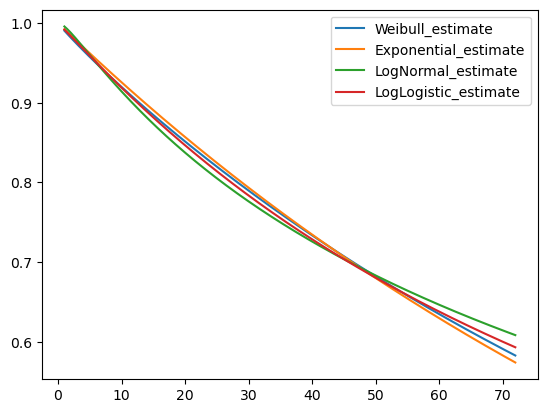

In [6]:
for model in [wf, ex, lnf, llf]:
    model.fit(durations = telco_df["tenure"], event_observed = telco_df["churn"])
    model.plot_survival_function(ci_show=False)

### Visually, the survival curves of the four models show remarkable similarity, displaying only minor differences. Notably, towards the latter part of the time frame, the LogNormal model exhibits the highest value of survival probability.

### Now let's calculate the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) for each model to compare their performance.

In [7]:
models_metrics = []

for model in [wf, ex, lnf, llf]:
    model.fit(durations = df_encoded['tenure'], event_observed=df_encoded['churn'])
    models_metrics.append((model.__class__.__name__, model.AIC_, model.BIC_))

models_metrics.sort(key=lambda x: x[1]) 

print("Model Performance Metrics:")
for model_name, aic_value, bic_value in models_metrics:
    print(f"{model_name}:\n  AIC: {aic_value}\n  BIC: {bic_value}\n")

Model Performance Metrics:
LogNormalFitter:
  AIC: 3209.0351474316735
  BIC: 3218.850657989638

LogLogisticFitter:
  AIC: 3214.4154757933375
  BIC: 3224.230986351302

ExponentialFitter:
  AIC: 3215.9608134637247
  BIC: 3220.868568742707

WeibullFitter:
  AIC: 3216.8611706815464
  BIC: 3226.676681239511



### Based on the output, the LogNormalFitter has the lowest AIC (3209.03) and BIC (3218.85) values among the models. In model selection criteria, the model with the lowest AIC or BIC is generally considered the best fit for the data.

## Now it is the time to explore AFT models: WeibullAFTFitter, LogNormalAFTFitter, and LogLogisticAFTFitter, excluding ExponentialAFTFitter as it's not available in my environment.

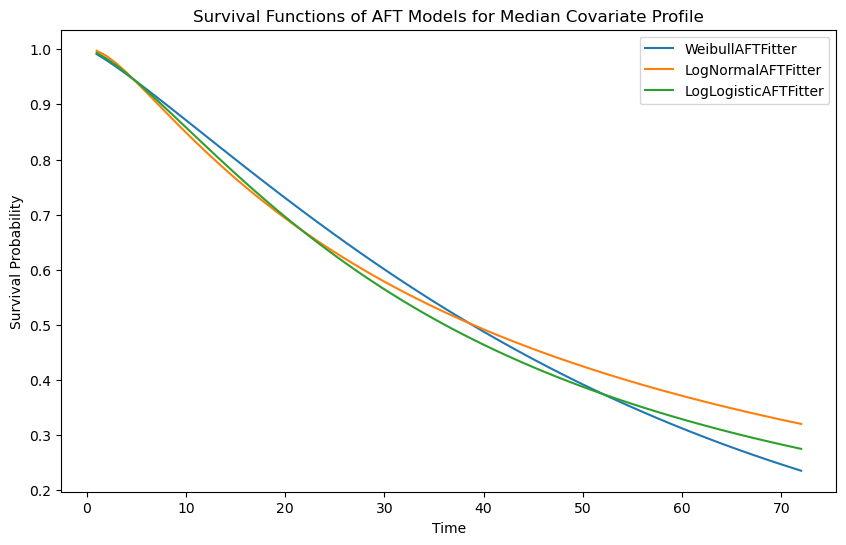

In [8]:
wf_aft = WeibullAFTFitter()
lnf_aft = LogNormalAFTFitter()
llf_aft = LogLogisticAFTFitter()

for model in [wf_aft, lnf_aft, llf_aft]:
    model.fit(df_encoded, 'tenure', event_col='churn')

covariate_values = df_encoded.median().to_frame().T

plt.figure(figsize=(10, 6))
for model in [wf_aft, lnf_aft, llf_aft]:
    survival_function = model.predict_survival_function(covariate_values)
    plt.plot(survival_function, label=model.__class__.__name__)
plt.title('Survival Functions of AFT Models for Median Covariate Profile')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

### Visually, the survival curves of the three AFT models show some differences. Notably, towards the latter part of the time frame, the LogNormal model exhibits the highest value of survival probability.

In [9]:
# Now let's analyze the AIC and BIC values.
models_metrics = []
for model in [wf_aft, lnf_aft, llf_aft]:
    models_metrics.append((model.__class__.__name__, model.AIC_, model.BIC_))

models_metrics.sort(key=lambda x: x[1]) 

print("Model Performance Metrics:")
for model_name, aic_value, bic_value in models_metrics:
    print(f"{model_name}:\n  AIC: {aic_value}\n  BIC: {bic_value}\n")

Model Performance Metrics:
LogNormalAFTFitter:
  AIC: 2954.0240102517128
  BIC: 2927.839520809677

LogLogisticAFTFitter:
  AIC: 2956.2085614433336
  BIC: 2930.024072001298

WeibullAFTFitter:
  AIC: 2964.3432480838806
  BIC: 2938.158758641845



### The LogNormalAFTFitter is the preferred model, having the lowest AIC (2954.024) and BIC (2927.8395) values. As a final conclusion, both LogNormalAFTFitter and LogNormalFitter emerge as the best choices in their respective analyses. So for the further work I will be using the LogNormalAFTFitter().

In [10]:
from lifelines import LogNormalAFTFitter
lnf = LogNormalAFTFitter()
lnf.fit(df_encoded, duration_col='tenure', event_col='churn')
lnf.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1457.01
         time fit was run = 2023-11-27 11:45:29 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                               
mu_    address                           0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                               0.03       1.03       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service                 1.07       2.90       0.17             0.73             1.40                 2.08                 4.06
       custcat_Plus service              0.92       2.52       0.22             0.50             1.35                 1.65                 3.85
       custcat_Total service             1.20       3.32       0.25             0.71             1.69                 2.03                 5.42
       ed_Did not complete high school   0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
       ed_High school degree             0.32       1.37       0.16            -0.00             0.64                 1.00                 1.89
       ed_Post-undergraduate degree     -0.03       0.97       0.22            -0.47             0.40                 0.62                 1.50
       ed_Some college                   0.27       1.31       0.17            -0.05             0.60                 0.95                 1.82
       forward_Yes                      -0.20       0.82       0.18            -0.55             0.15                 0.58                 1.17
       gender_Male                       0.05       1.05       0.11            -0.17             0.28                 0.84                 1.32
       income                            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
       internet_Yes                     -0.77       0.46       0.14            -1.05            -0.49                 0.35                 0.61
       marital_Unmarried                -0.46       0.63       0.12            -0.68            -0.23                 0.51                 0.80
       region_Zone 2                    -0.10       0.91       0.14            -0.38             0.18                 0.69                 1.20
       region_Zone 3                     0.05       1.05       0.14            -0.23             0.33                 0.80                 1.38
       retire_Yes                        0.02       1.02       0.44            -0.85             0.89                 0.43                 2.44
       voice_Yes                        -0.43       0.65       0.17            -0.76            -0.10                 0.47                 0.90
       Intercept                         2.36      10.61       0.29             1.79             2.94                 5.98                18.84
sigma_ Intercept                         0.28       1.32       0.05             0.19             0.37                 1.20                 1.44

                                         cmp to     z      p   -log2(p)
param  covariate                                                       
mu_    address                             0.00  4.78 <0.005      19.11
       age                                 0.00  4.50 <0.005      17.19
       custcat_E-service                   0.00  6.25 <0.005      31.21
       custcat_Plus service                0.00  4.29 <0.005      15.75
       custcat_Total service               0.00  4.79 <0.005      

### In the survival analysis of the telco dataset, several variables emerged as statistically significant. These include 'address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'internet_Yes', 'marital_Unmarried', and 'voice_Yes', along with the model intercepts 'mu Intercept' and 'sigma Intercept'. Each of these variables showed a p-value of less than 0.005, indicating a strong significance in the model. This suggests that these factors are crucial in predicting customer churn in the telecommunications context.


### Comment on significant cases
- **'address' (Coef = 0.04):** A positive coefficient suggests that a longer tenure at the same address slightly increases the duration until churn, indicating more stability.
- **'age' (Coef = 0.03):** A positive coefficient indicates that older customers are slightly more likely to stay longer before churning.
- **'custcat_E-service' (Coef = 1.07):** A large positive coefficient implies that customers in the E-service category are significantly more likely to churn later compared to the base category.
- **'custcat_Plus service' (Coef = 0.92) and 'custcat_Total service' (Coef = 1.20):** Both coefficients being positive and substantial suggest that customers in Plus and Total service categories have a delayed churn compared to the base categoels.
- **'internet_Yes' (Coef = -0.77):** The negative coefficient here implies that having internet service is associated with a shorter duration before churning, a factor to consider in retention strategies.
- **'marital_Unmarried' (Coef = -0.46):** A negative coefficient suggests that unmarried customers are more likely to churn sooner.
- **'voice_Yes' (Coef = -0.43):** This negative value indicates that customers who have subscribed to voice services are at a higher risk of churning sooner.
- **'mu Intercept' (Coef = 2.36) and 'sigma Intercept' (Coef = 0.28):** These intercepts are significant, indicating that the baseline level of churn risk and the variance of churn times across individuals are important factors in the model.
ooner.
sooner.

In [11]:
significant_features = [
    'address', 'age', 'custcat_E-service', 'custcat_Plus service', 
    'custcat_Total service', 'internet_Yes', 
    'marital_Unmarried', 'voice_Yes'
]
df_significant = df_encoded[significant_features + ['tenure', 'churn']]

lnf_significant = LogNormalAFTFitter()
lnf_significant.fit(df_significant, duration_col='tenure', event_col='churn')

lnf_significant.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 1000 total observations, 726 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
   number of observations = 1000
number of events observed = 274
           log-likelihood = -1462.10
         time fit was run = 2023-11-27 11:45:31 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                     
mu_    address                 0.04       1.04       0.01             0.03             0.06                 1.03                 1.06
       age                     0.04       1.04       0.01             0.02             0.05                 1.02                 1.05
       custcat_E-service       1.03       2.79       0.17             0.69             1.36                 2.00                 3.89
       custcat_Plus service    0.82       2.28       0.17             0.49             1.15                 1.63                 3.17
       custcat_Total service   1.01       2.75       0.21             0.60             1.42                 1.83                 4.15
       internet_Yes           -0.84       0.43       0.14            -1.11            -0.57                 0.33                 0.57
       marital_Unmarried      -0.45       0.64       0.11            -0.67            -0.22                 0.51                 0.80
       voice_Yes              -0.46       0.63       0.17            -0.79            -0.14                 0.45                 0.87
       Intercept               2.53      12.62       0.24             2.06             3.01                 7.84                20.30
sigma_ Intercept               0.28       1.33       0.05             0.19             0.37                 1.21                 1.45

                               cmp to     z      p   -log2(p)
param  covariate                                             
mu_    address                   0.00  4.84 <0.005      19.56
       age                       0.00  5.75 <0.005      26.78
       custcat_E-service         0.00  6.07 <0.005      29.53
       custcat_Plus service      0.00  4.85 <0.005      19.66
       custcat_Total service     0.00  4.83 <0.005      19.52
       internet_Yes              0.00 -6.08 <0.005      29.63
       marital_Unmarried         0.00 -3.91 <0.005      13.39
       voice_Yes                 0.00 -2.78   0.01       7.52
       Intercept                 0.00 10.45 <0.005      82.47
sigma_ Intercept                 0.00  6.15 <0.005      30.27
---
Concordance = 0.78
AIC = 2944.20
log-likelihood ratio test = 280.83 on 8 df
-log2(p) of ll-ratio test = 183.73

### Comment on the results after the change - The model above only includes the significant variables identified from the previous analysis, namely 'address', 'age', 'custcat_E-service', 'custcat_Plus service', 'custcat_Total service', 'ed_High school degree', 'internet_Yes', 'marital_Unmarried', and 'voice_Yes', along with 'mu Intercept' and 'sigma Intercept'.  Post-adjustment, the AIC value has decreased to 2944.20, signaling an improvement in the model's fit with these focused predictors. This decrease in AIC underscores the enhanced explanatory power and efficiency of the model by concentrating on these key variables.

- **'address' (Coef = 0.04):** A positive coefficient suggests that a longer tenure at the same address slightly increases the duration until churn, indicating more stability.
- **'age' (Coef = 0.04):** A positive coefficient indicates that older customers are slightly more likely to stay longer before churning.
- **'custcat_E-service' (Coef = 1.03):** A large positive coefficient implies that customers in the E-service category are significantly more likely to churn later compared to the base category.
- **'custcat_Plus service' (Coef = 0.82):** A positive coefficient suggests that customers in the Plus service category are likely to have a delayed churn compared to the base category.
- **'custcat_Total service' (Coef = 1.01):** A positive coefficient indicates that customers in the Total service category are significantly more likely to churn later compared to the base category.
- **'internet_Yes' (Coef = -0.84):** The negative coefficient here implies that having internet service is associated with a shorter duration before churning, a factor to consider in retention strategies.
- **'marital_Unmarried' (Coef = -0.45):** A negative coefficient suggests that unmarried customers are more likely to churn sooner.
- **'voice_Yes' (Coef = -0.46):** This negative value indicates that customers who have subscribed to voice services are at a higher risk of churning sooner.
- **'mu Intercept' (Coef = 2.53):** A significant positive coefficient for the mu Intercept indicates a higher baseline churn risk.
- **'sigma Intercept' (Coef = 0.28):** The significant sigma Intercept suggests a variance in churn times across indi
### From a business perspective, these results suggest that customer loyalty is influenced by stability (address tenure) and demographics (age, marital status). Notably, service types (E-service, Plus, Total) greatly impact churn, with internet service increasing churn risk. This highlights the need for targeted retention strategies, especially for internet and voice service subscribers, and underscores the importance of understanding customer segments for effective business decision-making.viduals.





# Compute CLV

In [12]:
telco = pd.read_csv("telco.csv")

In [13]:
pred_ = lnf_significant.predict_survival_function(df_significant).iloc[:12]
pred_

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
1.0,0.999688,0.999736,0.999999,0.997985,0.999870,0.999934,0.996781,0.993548,0.999994,0.999997,...,0.999828,0.999961,0.999668,1.000000,0.999781,0.996036,0.995073,0.999991,0.999923,0.999471
2.0,0.998129,0.998378,0.999988,0.990703,0.999127,0.999519,0.986180,0.975242,0.999946,0.999965,...,0.998883,0.999699,0.998022,0.999998,0.998622,0.983532,0.980236,0.999915,0.999446,0.997040
3.0,0.995250,0.995831,0.999956,0.979723,0.997635,0.998631,0.971075,0.951403,0.999818,0.999879,...,0.997036,0.999113,0.995004,0.999992,0.996407,0.966176,0.960211,0.999724,0.998443,0.992790
4.0,0.991268,0.992267,0.999893,0.966472,0.995448,0.997273,0.953528,0.925327,0.999593,0.999724,...,0.994377,0.998186,0.990846,0.999979,0.993269,0.946364,0.937776,0.999396,0.996923,0.987122
5.0,0.986400,0.987874,0.999796,0.951860,0.992655,0.995483,0.934724,0.898616,0.999264,0.999491,...,0.991029,0.996934,0.985782,0.999957,0.989366,0.925411,0.914381,0.998926,0.994934,0.980384
6.0,0.980833,0.982817,0.999659,0.936468,0.989349,0.993308,0.915365,0.872090,0.998828,0.999179,...,0.987108,0.995383,0.980004,0.999925,0.984837,0.904064,0.890812,0.998314,0.992532,0.972845
7.0,0.974715,0.977228,0.999483,0.920676,0.985608,0.990795,0.895877,0.846177,0.998286,0.998785,...,0.982712,0.993560,0.973669,0.999880,0.979801,0.882762,0.867512,0.997565,0.989769,0.964713
8.0,0.968166,0.971217,0.999264,0.904736,0.981502,0.987984,0.876524,0.821099,0.997643,0.998313,...,0.977926,0.991495,0.966899,0.999824,0.974355,0.861767,0.844730,0.996685,0.986693,0.956144
9.0,0.961281,0.964870,0.999004,0.888819,0.977091,0.984916,0.857473,0.796960,0.996902,0.997763,...,0.972818,0.989211,0.959795,0.999753,0.968579,0.841235,0.822606,0.995682,0.983348,0.947260
10.0,0.954136,0.958260,0.998703,0.873040,0.972424,0.981623,0.838827,0.773801,0.996068,0.997139,...,0.967448,0.986734,0.952434,0.999669,0.962537,0.821255,0.801210,0.994563,0.979769,0.938154


In [14]:
monthly_margin = 950 #assumption
pred = pred_*monthly_margin
rate  = 0.15
pred = pd.DataFrame({col: [pred.iloc[row-1, col-1] / (1 + rate)**(row-1) for row in range(1, 13)] for col in range(1, len(pred.columns)+1)})

In [15]:
telco["CLV_pred"] = list(pred.iloc[11])

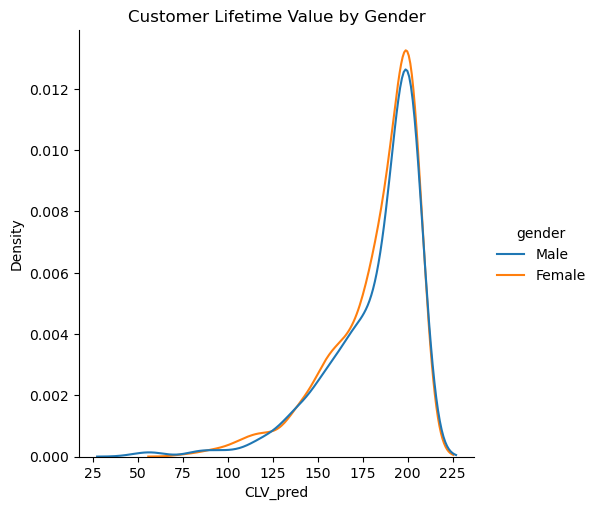

In [16]:
clv_gender = sns.displot(telco, x = 'CLV_pred', kind = 'kde', hue = 'gender')
clv_gender.set(title='Customer Lifetime Value by Gender')

### Comment on plot "Customer Lifetime Value by Gender" - This plot reveals that in the telecom dataset, both male and female customers exhibit similar CLV distributions, suggesting that gender may not be a primary factor influencing customer value. This similarity implies that gender-targeted marketing or service strategies might not significantly impact CLV, and other customer attributes could be more influential for business strategy.

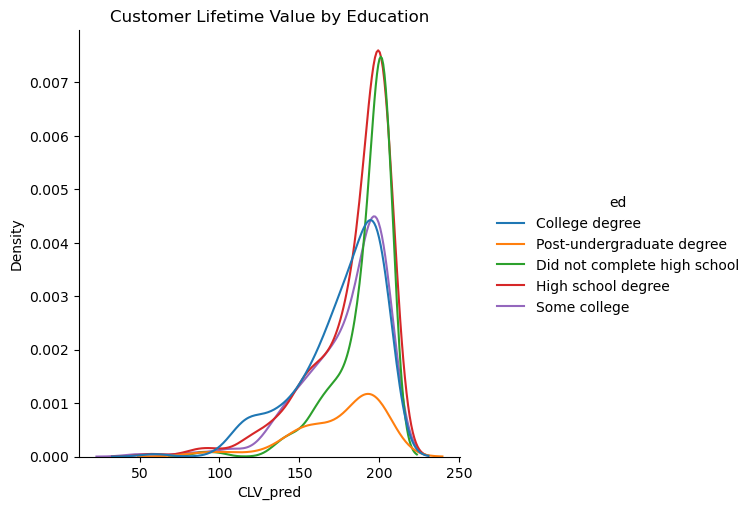

In [17]:
clv_ed = sns.displot(telco, x = 'CLV_pred', kind = 'kde', hue = 'ed')
clv_ed.set(title='Customer Lifetime Value by Education')

### Comment on plot "Customer Lifetime Value by educational level" - This plot reveals interesting patterns in the distribution of Customer Lifetime Value (CLV) across different educational groups. Notably, the groups with 'High School Degree' and 'Did Not Complete High School' exhibit the highest density, with their peak CLV values ranging around 200. Following these are the 'College Degree' and 'Some College' groups, which share a similar density level. In contrast, the 'Post-Undergraduate Degree' group shows the lowest density among all. An intriguing observation is that despite these differences in density, all educational groups' curves peak within the same CLV range. This suggests that irrespective of educational background, there is a common range of CLV prevalent among customers. The higher prevalence of the 'High School Degree' and 'Did Not Complete High School' groups could indicate that younger customers or those with lower educational attainment are more engaged with the business's services.

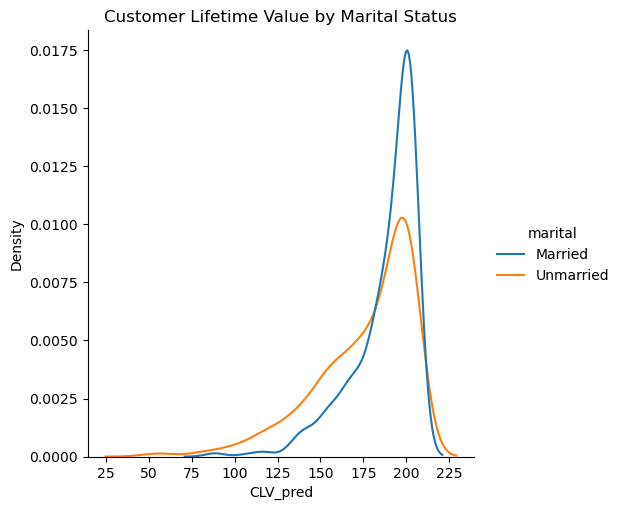

In [18]:
clv_martial = sns.displot(telco, x = 'CLV_pred', kind = 'kde', hue = 'marital')
clv_martial.set(title='Customer Lifetime Value by Marital Status')

### Comment - The "Customer Lifetime Value by Marital Status" plot shows that the married group exhibits a higher density value, suggesting they might have a more consistent and potentially higher CLV. In contrast, the unmarried group has a lower density, indicating a broader range of CLV but generally lower values. From a marketing perspective, this suggests that targeting married customers could yield more consistent returns, while strategies for the unmarried group may need to be more diverse and innovative to capture the varied range of their CLV.

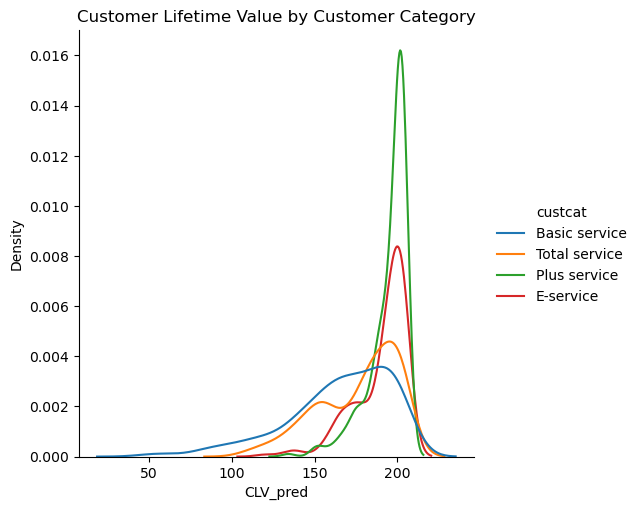

In [19]:
clv_custcat = sns.displot(telco, x = 'CLV_pred', kind = 'kde', hue = 'custcat')
clv_custcat.set(title='Customer Lifetime Value by Customer Category')

### Comment - The plot "Customer Lifetime Value by Customer Category" reveals distinct CLV distributions among different service categories. The "Plus Service" group shows the highest density and a unimodal distribution, indicating a strong, consistent CLV pattern. Following this, the "E-Service" group also displays a unimodal distribution with the second-highest density. Interestingly, the "Total Service" category is bimodal with the third highest density, suggesting varied CLV within this segment. Lastly, the "Basic Service" group has the lowest density, also unimodal, pointing to a more uniform but lower CLV. We observe that customers using "Plus Service" and "E-Service" have higher and more consistent CLVs, likely reflecting their preference for more comprehensive or digital-oriented services, a trend that aligns with modern consumers' increasing reliance on digital connectivity. The varied CLV in the "Total Service" group could indicate a mix of highly engaged and less engaged customers. In contrast, the "Basic Service" users, with the lowest CLV, might represent a more price-sensitive segment or those with minimal service needs, a common trend in diverse customer bases. These insights can guide focused marketing efforts to leverage these trends and enhance service offerings.

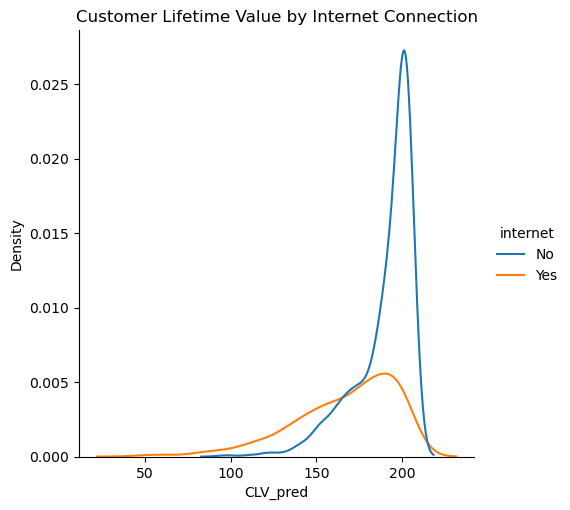

In [20]:
clv_internet = sns.displot(telco, x='CLV_pred', kind='kde', hue='internet')
clv_internet.set(title='Customer Lifetime Value by Internet Connection')

### Comment - The significantly high density of the "No" category in the "Customer Lifetime Value by Internet Connection" plot suggests that a large segment of customers without internet services tend to have a similar and possibly lower range of CLV. This could be indicative of a customer base that is either less reliant on digital services or more price-sensitive, choosing only basic telecom services. This trend reflects a real-world scenario where a substantial customer group opts for traditional or basic telecom services over added digital connectivity, impacting their overall lifetime value to the company.

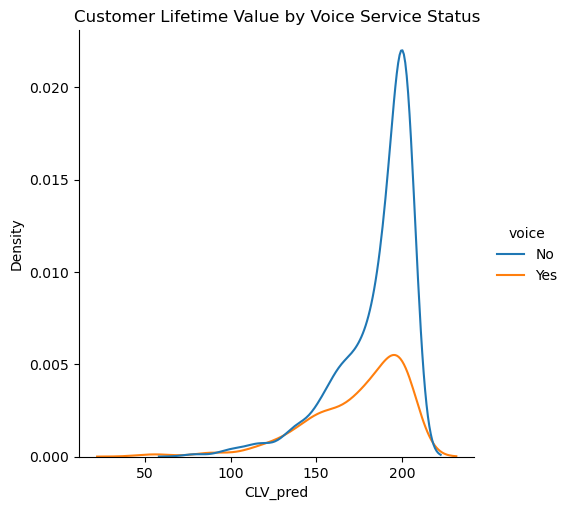

In [21]:
clv_voice = sns.displot(telco, x='CLV_pred', kind='kde', hue='voice')
clv_voice.set(title='Customer Lifetime Value by Voice Service Status')

### Comment - In the "Customer Lifetime Value by Voice Service Status" plot, the "No" category's high density suggests that a substantial portion of customers without voice services have a closely clustered CLV. This trend may reflect a customer segment less engaged with voice communication, possibly due to a preference for data-driven communication methods like messaging or internet services. It indicates a shift in customer communication preferences, with a significant group possibly favoring modern, data-centric services over traditional voice calls, impacting their overall contribution to the company's customer lifetime value.

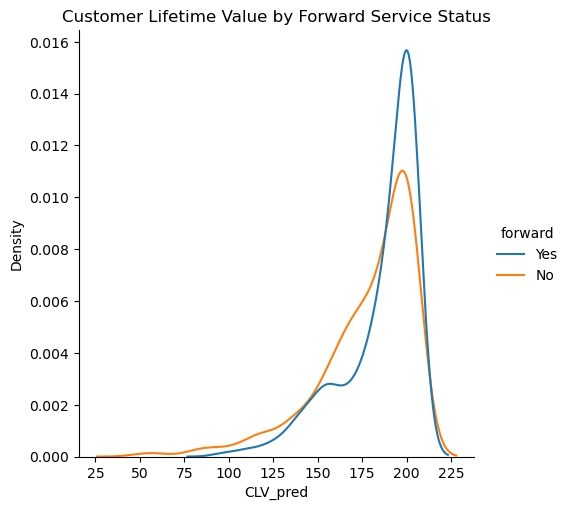

In [22]:
clv_forward = sns.displot(telco, x='CLV_pred', kind='kde', hue='forward')
clv_forward.set(title='Customer Lifetime Value by Forward Service Status')

### Comment - The high density of the "No" category in the "Customer Lifetime Value by Forward Service Status" plot suggests that a large group of customers without forward services has a closely bunched CLV. This could indicate that these customers are either less interested in or less aware of the benefits of forward services, possibly prioritizing other features or services. Their concentration in a specific CLV range also implies a more homogeneous group in terms of service usage and spending patterns, highlighting an opportunity for targeted marketing to educate and encourage them about the advantages of forward services.

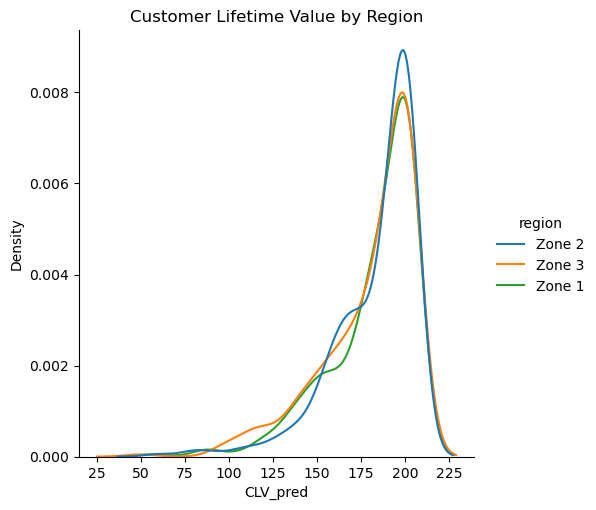

In [23]:
clv_region = sns.displot(telco, x='CLV_pred', kind='kde', hue='region')
clv_region.set(title='Customer Lifetime Value by Region')

### Comment - The "Customer Lifetime Value by Region" plot reveals that 'Zone 2' exhibits a slightly higher density value compared to 'Zone 1' and 'Zone 3'. This indicates that customers in 'Zone 2' might have a more consistent and potentially higher CLV. The similar distributions across all regions suggest that regional differences in CLV are subtle, yet the slight edge for 'Zone 2' could point towards unique regional preferences or behaviors influencing customer value. Understanding these nuances is key for regional marketing strategies and service tailoring in the telecom industry.

## Marketing Analytics: Valuable Customer Segments

In the field of Marketing Analytics, a **valuable segment** is one that demonstrates high **Customer Lifetime Value (CLV)** and lower **churn risk**. Based on the analysis:

### Service Category
- **Plus Service and E-Service** customers show higher and consistent CLVs, indicating higher engagement and profitability.

### Marital Status
- **Married** customers have higher and more consistent CLVs, suggesting greater stability and value.

### Educational Level
- Despite varied densities, all groups peak in the same CLV range, but **High School Degree** and **Did Not Complete High School** groups are more engaged.

### Internet Service
- Customers **without internet service** tend to have lower and similar CLVs, indicating a segment less engaged or prioritizing basic telecom services.

### Voice Service
- Customers **without voice services** often have a clustered lower CLV, suggesting less engagement with traditional voice communication.

### Forward Service
- A large group **without forward services** shows homogeneity in CLV, highlighting potential for targeted marketing to promote these services.

### Region
- Customers in **Zone 2** exhibit slightly higher CLV, indicating a region-specific opportunity.


### To calculate the annual retention budget, assuming the data represents the population, the focus should be on the Customer Lifetime Value (CLV), survival probabilities, and identifying the number of at-risk subscribers within a year.

In [24]:
survival_threshold = 0.75
at_risk_customers = pred_.iloc[11][pred_.iloc[11] < survival_threshold].count()
cost_per_customer = 150  # This is an assumption and can vary based on the business context
annual_retention_budget = at_risk_customers * cost_per_customer

print("Survival Threshold: {:.2f}".format(survival_threshold))
print("Number of Customers at Risk (12 Months): {}".format(at_risk_customers))
print("Cost per Customer for Retention Efforts: ${}".format(cost_per_customer))
print("Annual Retention Budget: ${}".format(annual_retention_budget))

Survival Threshold: 0.75
Number of Customers at Risk (12 Months): 135
Cost per Customer for Retention Efforts: $150
Annual Retention Budget: $20250


### Conclusion - With a survival probability threshold of 0.75, there are 135 customers identified as being at risk of churning within one year. Assuming a cost of 150 USD per customer for retention efforts, the calculated annual retention budget would be 20250 USD.

### Final suggestion for retention - I recommend a personalized approach to customer retention. This involves tailoring communication and offers based on individual customer profiles, usage patterns, and preferences. Engaging customers through loyalty programs and offering incentives for long-term contracts can enhance retention. Additionally, implementing feedback mechanisms to understand customer dissatisfaction and promptly addressing issues is crucial. Proactive customer service, especially for high-risk segments identified in the analysis, can significantly reduce churn. Leveraging data analytics to predict and prevent potential churn before it happens is key in modern retention strategies. This comprehensive approach combines theoretical knowledge with practical experience in telecommunication customer retention.